In [1]:
import h5py
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense, ReLU, Dropout, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam

tf.compat.v1.disable_eager_execution()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
with h5py.File('/content/drive/MyDrive/thesis/v_dataset_itop.hdf5', 'r') as hf:
    x_train = np.asarray(hf['x_train'])
    y_train = np.asarray(hf['y_train'])
    x_test  = np.asarray(hf['x_test'])
    y_test  = np.asarray(hf['y_test'])

_, img_w, img_h = x_train.shape

x_train = np.reshape(x_train, (-1, img_w, img_h, 1))
x_test  = np.reshape(x_test,  (-1,  img_w, img_h, 1))

print(x_train.shape)
print(x_test.shape)

(17991, 192, 112, 1)
(4863, 192, 112, 1)


In [5]:
def centre_joints(joint_positions):
  if len(y_train.shape) != 3:
    joint_positions = joint_positions.reshape((-1, 15, 3))
  # Find the coordinates of joint 8 for each N
  torso_coords = joint_positions[:, 8, :]

  # Subtract the coordinates of joint 8 from all joint positions
  joint_positions_centered = joint_positions - torso_coords[:, np.newaxis, :]

  return np.reshape(joint_positions_centered, (-1, 45, 1))

norm_train = centre_joints(y_train)
norm_test  = centre_joints(y_test)

In [6]:
import random
idx = random.randint(0, len(x_train))

x = norm_train.reshape((-1, 15, 3))
y = y_train.reshape((-1, 15, 3))

for i in range(x_train.shape[0]):
  dist1 = np.linalg.norm(x[i,6,:] - x[i,7,:])
  dist2 = np.linalg.norm(y[i,6,:] - y[i,7,:])
  if dist1 != dist2:
    print(f"DIFF DISTANCE: {i}")

(15, 3)
(15, 3)


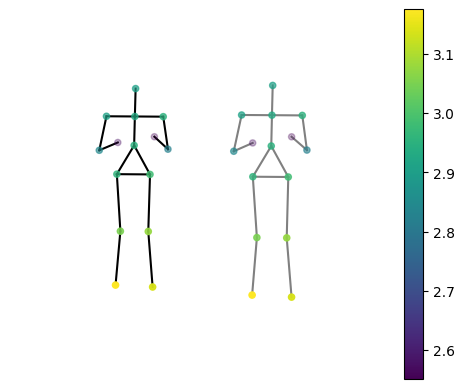

In [7]:
import random
idx = random.randint(0, x_train.shape[0])

joint_map = [[0,1],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7],[1,8],[8,9],[8,10],[9,10],[9,11],[10,12],[11,13],[12,14]]

def plot_joint_pos(joints, color):
  if joints.shape[0] != 15:
    joints = joints.reshape((15, 3))

  print(joints.shape)
  dx, dy, dz = zip(*joints)

  for p, c in joint_map: # parent and child
    ax.plot([dx[p], dx[c]], [dy[p], dy[c]], [dz[p], dz[c]], '-', c=color)
  p = ax.scatter3D(dx, dy, dz, c=dz)
  return p

fig = plt.figure()
ax = plt.axes(projection='3d')

plot_joint_pos(norm_train[idx], 'black')

yt = np.reshape(y_train[idx], (15, 3))
yt[:, 0] = yt[:, 0]+1
p = plot_joint_pos(yt, 'grey')

fig.colorbar(p)

ax.view_init(elev=90, azim=-90)
plt.grid(visible=None)
plt.axis('off')
plt.show()

# Beta Annealing

In [15]:
class BetaAnnealingScheduler:
    def __init__(self, n_epoch, anneal_type):
        """
        [1] - https://github.com/haofuml/cyclical_annealing
        """
        self.n_epoch = n_epoch

        self.start = 0.0
        self.stop = 1.0
        self.c = 1.0

        if anneal_type == "sigmoid":
            self.L = self.frange_cycle_sigmoid()
        elif anneal_type == "cosine":
            self.L = self.frange_cycle_cosine()
        else: # Linear
            self.L = self.frange_cycle_linear()

    def frange_cycle_linear(self, n_cycle=4, ratio=0.5):
        L = np.ones(self.n_epoch)
        period = self.n_epoch / n_cycle
        step = (self.stop - self.start) / (period * ratio)  # linear schedule

        for c in range(n_cycle):
            v, i = self.start, 0
            while v <= self.stop and (int(i + c * period) < self.n_epoch):
                L[int(i + c * period)] = v
                v += step
                i += 1

        self.L = L * self.c
        return self.L

    def frange_cycle_sigmoid(self, n_cycle=4, ratio=0.5):
        L = np.ones(self.n_epoch)
        period = self.n_epoch / n_cycle
        step = (self.stop - self.start) / (period * ratio)  # step is in [0,1]

        for c in range(n_cycle):
            v, i = self.start, 0
            while v <= self.stop:
                L[int(i + c * period)] = 1.0 / (1.0 + np.exp(-(v * 12.0 - 6.0)))
                v += step
                i += 1

        self.L = L * self.c
        return self.L

    def frange_cycle_cosine(self, n_cycle=4, ratio=0.5):
        L = np.ones(self.n_epoch)
        period = self.n_epoch / n_cycle
        step = (self.stop - self.start) / (period * ratio)  # step is in [0,1]

        for c in range(n_cycle):

            v, i = self.start, 0
            while v <= self.stop:
                L[int(i + c * period)] = 0.5 - 0.5 * np.cos(v * np.pi)
                v += step
                i += 1

        self.L = L * self.c
        return self.L
    
    def __call__(self, i, *args, **kwargs):
        return self.L[i]

In [16]:
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint

path = '/content/drive/MyDrive/thesis/weights/'

beta = K.variable(value=0.0)

def beta_annealing(epoch):
    value = BetaAnnealingScheduler(n_epoch=num_epochs_to_train, anneal_type='sigmoid')(epoch)
    print("Beta value: {}".format(value))
    K.set_value(beta, value)

epoch_callback = LambdaCallback(on_epoch_begin=lambda epoch, log: beta_annealing(epoch))

mcp_save = ModelCheckpoint(path + '{epoch:03d}.hdf5', verbose=0, save_weights_only=True, save_freq='epoch')

# VAE model

## Build Model

In [17]:
def calculate_reconstruction_loss(y_target, y_predicted):
    error = y_target - y_predicted
    reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
    return reconstruction_loss


def calculate_kl_loss(model):
    def _calculate_kl_loss(*args):
        kl_loss = -0.5 * K.sum(1 + model.log_variance - K.square(model.mu) -
                               K.exp(model.log_variance), axis=1)
        return beta * kl_loss
    return _calculate_kl_loss

In [18]:
class VAE:
  def __init__(self,
               model_input, #shape of the input data
               conv_filters, #convolutional network filters
               conv_kernels, #convNet kernel size
               conv_strides, #convNet strides
               latent_space_dim):
    self.model_input = model_input # (192, 112)
    self.conv_filters = conv_filters # is a list for each layer, i.e. [2, 4, 8]
    self.conv_kernels = conv_kernels # list of kernels per layer, [1, 2, 3]
    self.conv_strides = conv_strides # stride for each filter [1, 2, 2], note: 2 means you are downsampling the data in half
    self.latent_space_dim = latent_space_dim # how many neurons on bottleneck
    self.reconstruction_loss_weight = 100000

    self.encoder = None
    self.decoder = None
    self.model = None
    self.hist = None

    self._num_conv_layers = len(conv_filters)
    self._shape_before_bottleneck = None
    self._model_output = None
    self._model_input = None
    self._foi_input = None

    self._build()

  def _build(self):
    self._build_encoder()
    self._build_decoder()
    self._build_autoencoder()

  def compile(self, learning_rate=0.0001):
    optimizer = Adam(learning_rate=learning_rate)
    self.model.compile(optimizer=optimizer, loss=self._calculate_combined_loss,
                       metrics=[calculate_reconstruction_loss, calculate_kl_loss(self)])
  
  
  def train(self, x_train, batch_size, num_epochs):
    self.hist = self.model.fit(x_train, x_train,
                               batch_size=batch_size,
                               epochs=num_epochs,
                               shuffle=True)
    
  def _calculate_combined_loss(self, y_target, y_predicted):
    reconstruction_loss = calculate_reconstruction_loss(y_target, y_predicted)
    kl_loss = calculate_kl_loss(self)()
    combined_loss = reconstruction_loss * self.reconstruction_loss_weight + kl_loss
    return combined_loss

  #----------------FULL MODEL-----------------#
  def _build_autoencoder(self):
    model_input = self._model_input
    model_output = self.decoder(self.encoder(model_input))
    self.model = Model(model_input, model_output, name='autoencoder')

  #----------------DECODER-----------------#
  def _build_decoder(self):
    decoder_input = self._add_decoder_input()
    dense_layer = self._add_dense_layer(decoder_input)
    reshape_layer = self._add_reshape_layer(dense_layer)
    conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
    decoder_output = self._add_decoder_output(conv_transpose_layers)
    self.decoder = Model(decoder_input, decoder_output, name="decoder")
    self._model_output = self.decoder(self.encoder(self._model_input))
    

  def _add_decoder_input(self):
    return Input(shape=self.latent_space_dim, name="decoder_input")

  def _add_dense_layer(self, decoder_input):
    num_neurons = np.prod(self._shape_before_bottleneck) # [ 1, 2, 4] -> 8
    dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
    return dense_layer

  def _add_reshape_layer(self, dense_layer):
    return Reshape(self._shape_before_bottleneck)(dense_layer)

  def _add_conv_transpose_layers(self, x):
    for layer_index in reversed(range(1, self._num_conv_layers)):
      x = self._add_conv_transpose_layer(layer_index, x)
    return x

  def _add_conv_transpose_layer(self, layer_index, x):
    layer_num = self._num_conv_layers - layer_index
    conv_transpose_layer = Conv2DTranspose(
        filters=self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        activation='relu',
        padding = "same",
        name=f"decoder_conv_transpose_layer_{layer_num}"
    )
    x = conv_transpose_layer(x)
    x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
    return x

  def _add_decoder_output(self, x):
    conv_transpose_layer = Conv2DTranspose(
        filters = 1,
        kernel_size = self.conv_kernels[0],
        strides = self.conv_strides[0],
        padding = "same",
        name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
    )
    x = conv_transpose_layer(x)
    output_layer = Activation("sigmoid", name="sigmoid_output_layer")(x)
    return output_layer

  #----------------ENCODER-----------------#
  def _build_encoder(self):
    encoder_input = self.model_input
    conv_layers = self._add_conv_layers(encoder_input)
    bottleneck =  self._add_bottleneck(conv_layers)
    self._model_input = encoder_input
    self.encoder = Model(encoder_input, bottleneck, name="encoder")

  def _add_conv_layers(self, encoder_input):
    """Creates all convolutional blocks in encoder"""
    x = encoder_input
    for layer_index in range(self._num_conv_layers):
      x = self._add_conv_layer(layer_index, x)
    return x
  
  def _add_conv_layer(self, layer_index, x):
    """
    Adds a convolutional block to a graph of layers, consisting
    of Conv 2d + ReLu activation + batch normalization.
    """
    layer_number = layer_index + 1
    conv_layer = Conv2D(
        filters= self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        activation='relu',
        padding = "same",
        name = f"encoder_conv_layer_{layer_number}"
    )
    x = conv_layer(x)
    x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
    return x

  #-------------LATTENT SPACE-------------#
  def _add_bottleneck(self, x):
    """Flatten data and add bottleneck with Gaussian sampling (Dense layer)"""
    self._shape_before_bottleneck = K.int_shape(x)[1:]
    x = Flatten()(x)
    self.mu = Dense(self.latent_space_dim,name="mu")(x)
    self.log_variance = Dense(self.latent_space_dim,
                              name="log_variance")(x)
    
    def sample_point_from_normal_distribution(args):
      mu, log_variance = args
      epsilon = K.random_normal(shape=K.shape(self.mu), mean=0., stddev=1.)
      sampled_point = mu + K.exp(log_variance / 2) * epsilon

      return sampled_point

    x = Lambda(sample_point_from_normal_distribution, 
              name="encoder_output")([self.mu, self.log_variance])
    return x

In [19]:
learning_rate = 0.001     #@param {type:"raw"}
num_epochs_to_train = 30  #@param {type:"integer"}
batch_size = 64           #@param {type:"integer"}

## Training

In [ ]:
vector_dimension = 1024

filters = (256, 128, 32, 16)
kernels = (3, 3, 3, 3)
strides = (2, 2, 2, (2,1))

In [ ]:
depth_image_in = Input(shape=x_train.shape[1:], name='model_input')

vae = VAE(model_input = depth_image_in, 
          conv_filters=filters, 
          conv_kernels=kernels, 
          conv_strides=strides, 
          latent_space_dim = vector_dimension
          )

vae.encoder.summary()

In [ ]:
vae.compile(learning_rate)
out = vae.model.fit(noise_train, x_train,
                    callbacks=[epoch_callback, mcp_save],
                    batch_size=batch_size,
                    epochs=num_epochs_to_train,
                    shuffle=True)

In [ ]:
tf.keras.utils.plot_model(vae.model, expand_nested=True, show_shapes=True)

In [ ]:
loss = out.history['calculate_reconstruction_loss']

epochs = range(num_epochs_to_train)

plt.figure()
plt.plot(epochs, loss, 'g', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [ ]:
vae.model.load_weights('/content/drive/MyDrive/thesis/weights/new/noise01_e24_l11.hdf5')
depth_img_pred = vae.model.predict(x_test)

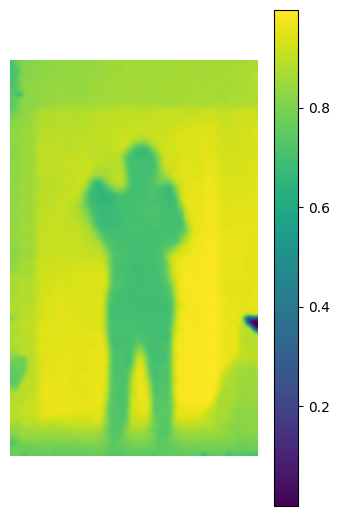

In [ ]:
plt.matshow(depth_img_pred[300], cmap=plt.cm.viridis, interpolation='bicubic')
plt.colorbar()

plt.grid(visible=None)
plt.axis('off')
plt.show()

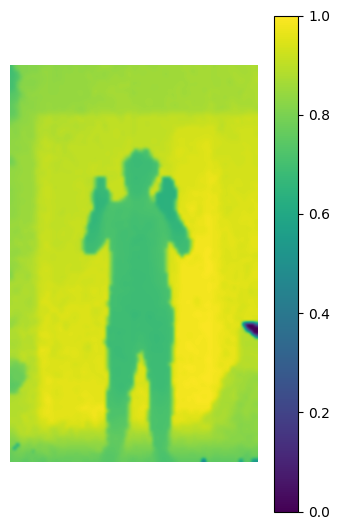

In [ ]:
plt.matshow(x_test[300], cmap=plt.cm.viridis, interpolation='bicubic')
plt.colorbar()

plt.grid(visible=None)
plt.axis('off')
plt.show()

# Classifier

In [20]:
class MLP():
  def __init__(self, encoder, input_dim, input_image):
    self.encoder = encoder
    self.input_dim = input_dim
    self.input_image = input_image

    self.encoder.trainable = False
    
    self.model = None
    self.mlp_output = None
    self.mlp_model  = self._build_mlp()

    self._build()

  def _build(self):
    self.mlp_output = self.mlp_model(self.encoder(self.input_image, training=False))
    self.model = Model(inputs=self.input_image, outputs=self.mlp_output, name='vae_classifier')

  def compile(self, learning_rate=0.0001):
    self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
  
  def train(self, x_train, y_train, batch_size, num_epochs):
    self.hist = self.model.fit(x_train, y_train,
                               batch_size=batch_size,
                               epochs=num_epochs,
                               shuffle=True)

  def _build_mlp(self):
      mlp_input = self._add_mlp_input()
      mlp_output = self._add_mlp_layers(mlp_input)
      return Model(mlp_input, mlp_output, name="MLP_model")

  def _add_mlp_input(self):
    return Input(shape=self.input_dim, name="mlp_input")

  def _add_mlp_layers(self, x):
    dimension = self.input_dim

    while dimension >= 256:
       x = Dense(dimension, name=f"dense_{dimension}")(x)
       x = BatchNormalization(name=f"bnorm_{dimension}")(x)
       x = ReLU()(x)
       x = Dropout(0.5, name=f"dropout_{dimension}")(x)
       dimension = dimension / 2

    d_layer = Dense(45, activation='linear', name='dense_45')(x)
    r_layer = Reshape((45, 1), name='mlp_output')(d_layer)
    return r_layer

In [35]:
batch_size = 128
num_epochs_to_train = 200

vector_dimension = 512

filters = (512, 256, 128, 64, 32)
kernels = (3, 3, 3, 3, 3)
strides = (2, 2, 2, 2, (2,1))

depth_image_in = Input(shape=x_train.shape[1:], name='model_input')
vae = VAE(model_input = depth_image_in, 
          conv_filters=filters, 
          conv_kernels=kernels, 
          conv_strides=strides, 
          latent_space_dim = vector_dimension
          )

vae.model.load_weights('/content/drive/MyDrive/thesis/weights/large/512_256_128_64_32_d512_e16_0016.hdf5')

In [ ]:
model = MLP(encoder=vae.encoder, input_dim=vector_dimension, input_image=depth_image_in)
model.compile()
model.mlp_model.summary()
out = model.train(x_train, norm_train, batch_size, num_epochs_to_train)

Model: "MLP_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mlp_input (InputLayer)      [(None, 512)]             0         
                                                                 
 dense_512 (Dense)           (None, 512)               262656    
                                                                 
 bnorm_512 (BatchNormalizati  (None, 512)              2048      
 on)                                                             
                                                                 
 re_lu_3 (ReLU)              (None, 512)               0         
                                                                 
 dropout_512 (Dropout)       (None, 512)               0         
                                                                 
 dense_256.0 (Dense)         (None, 256)               131328    
                                                         

In [ ]:
y_pred = model.model.predict(x_test)

In [24]:
# mAP calculating
batch_size = norm_test.shape[0]
threshold = 1

gt_joints   = norm_test.reshape((-1, 15, 3))
pred_joints = y_pred.reshape((-1, 15, 3))

# Define the number of joints for the human skeleton
num_joints = gt_joints.shape[1]

# Calculate the OKS score for each joint
oks_scores = np.zeros((num_joints,))
for i in range(batch_size):
  distances = np.zeros((num_joints,))
  for j in range(num_joints):
    distances[j] = np.linalg.norm(gt_joints[i][j] - pred_joints[i][j])
  oks_scores += distances < 0.1

oks_scores = oks_scores/batch_size

# Calculate the mean average precision (mAP) using the OKS scores
mAP = np.mean(oks_scores)*100

# Print the mAP
print(f"Mean Average Precision: {round(mAP,2)}")

Mean Average Precision: 70.47


In [25]:
joint_id_to_name = {
  0: 'Head', 1: 'Neck', 2: 'R Shoulder', 3: 'L Shoulder', 4: 'R Elbow', 5: 'L Elbow', 6: 'R Hand', 7: 'L Hand', 8: 'Torso', 9: 'R Hip', 10: 'L Hip', 11: 'R Knee', 12: 'L Knee', 13: 'R Foot', 14: 'L Foot',
}

for i, key in enumerate(joint_id_to_name):
  print('{:<10} {:>8}'.format(joint_id_to_name[key], round(oks_scores[i]*100, 2)))

Head          85.71
Neck          98.25
R Shoulder    88.51
L Shoulder    89.25
R Elbow       51.51
L Elbow        49.7
R Hand        26.51
L Hand        25.03
Torso         100.0
R Hip         95.37
L Hip         94.94
R Knee        72.86
L Knee         67.2
R Foot         53.9
L Foot         58.3


Head              1 0.009347
Neck              1 0.021172
R Shoulder        1 0.051151
L Shoulder        1 0.010967
R Elbow           1   0.0071
L Elbow           1 0.016275
R Hand            1 0.000795
L Hand            1 0.014172
Torso             1 0.063641
R Hip             1 0.017786
L Hip             1  0.00381
R Knee            1 0.025045
L Knee            1 0.039064
R Foot            1 0.049853
L Foot            0  0.11569


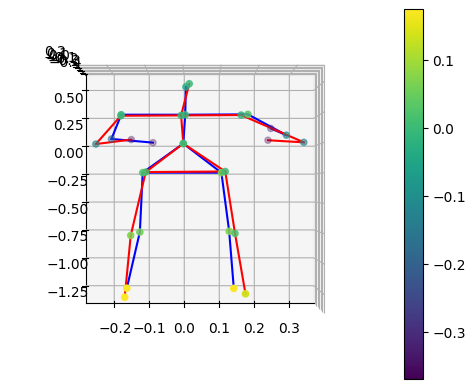

In [29]:
idx = random.randint(0, norm_test.shape[0])

distances = np.zeros((norm_test.shape[1],))
for j in range(norm_test.shape[1]):
    distances[j] = np.linalg.norm(norm_test[idx][j] - y_pred[idx][j])

for i, key in enumerate(joint_id_to_name):
  num = distances[i] < 0.1
  print('{:<10} {:>8} {:>8}'.format(joint_id_to_name[key], num, round(distances[i], 6)))

joint_map = [[0,1],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7],[1,8],[8,9],[8,10],[9,10],[9,11],[10,12],[11,13],[12,14]]

data = np.reshape(y_pred[idx], (15, 3))
dx, dy, dz = zip(*data)  

fig = plt.figure()
ax = plt.axes(projection='3d')

for parent, child in joint_map:
    ax.plot([dx[parent], dx[child]], 
            [dy[parent], dy[child]], 
            [dz[parent], dz[child]], 'b-')

p = ax.scatter3D(dx, dy, dz, c=dz)

dx, dy, dz = zip(*np.reshape(norm_test[idx], (15, 3)))

for parent, child in joint_map:
    ax.plot([dx[parent], dx[child]], 
            [dy[parent], dy[child]], 
            [dz[parent], dz[child]], 'r-')

p = ax.scatter3D(dx, dy, dz, c=dz)
fig.colorbar(p)

ax.view_init(elev=90, azim=-90)
plt.grid(visible=None)
#plt.axis('off')
plt.show()

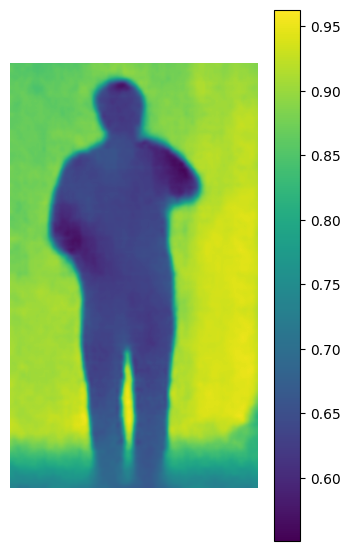

In [36]:
pred_depth = vae.model.predict(x_test)

idx = random.randint(0, norm_test.shape[0])

plt.matshow(pred_depth[idx], cmap=plt.cm.viridis, interpolation='bicubic')
plt.colorbar()

plt.grid(visible=None)
plt.axis('off')
plt.show()